In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install dependencies
!pip install -q speechbrain torchaudio scikit-learn umap-learn matplotlib seaborn tqdm

In [3]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torchaudio

from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [4]:
# ============================================================
# CONFIGURATION
# ============================================================

BASE_DIR = Path("/content/drive/MyDrive/Liquidity_Research/unified")
AUDIO_DIR = BASE_DIR / "audio_16k"
METADATA_PATH = BASE_DIR / "metadata.csv"
SPLITS_PATH = BASE_DIR / "splits.json"

# Output directories
FEATURES_DIR = BASE_DIR / "features"
SPEAKER_EMB_DIR = FEATURES_DIR / "speaker_embeddings"
RESULTS_DIR = BASE_DIR / "results"

# Create directories
SPEAKER_EMB_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Audio dir: {AUDIO_DIR}")
print(f"Output dir: {SPEAKER_EMB_DIR}")

Audio dir: /content/drive/MyDrive/Liquidity_Research/unified/audio_16k
Output dir: /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings


In [5]:
# Load metadata
df = pd.read_csv(METADATA_PATH)
print(f"Loaded {len(df):,} utterances")

# Load splits
with open(SPLITS_PATH) as f:
    splits = json.load(f)

# Add split column
df['split'] = 'unknown'
df.loc[df['speaker_id'].isin(splits['train']['speakers']), 'split'] = 'train'
df.loc[df['speaker_id'].isin(splits['val']['speakers']), 'split'] = 'val'
df.loc[df['speaker_id'].isin(splits['test']['speakers']), 'split'] = 'test'

print(f"\nSplits: {df['split'].value_counts().to_dict()}")

Loaded 61,911 utterances

Splits: {'train': 43171, 'val': 10041, 'test': 8699}


In [6]:
# ===========================
# ALTERNATIVE: Use WavLM (no version issues)
# ============================================================

!pip install -q transformers

import torch
import torchaudio
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector

print("Loading WavLM speaker model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus-sv")
model = WavLMForXVector.from_pretrained("microsoft/wavlm-base-plus-sv").to(device)
model.eval()

print(f"✅ Model loaded on {device}!")

Loading WavLM speaker model...
✅ Model loaded on cuda!


In [7]:
!pip install -q soundfile

In [8]:
import soundfile as sf
import numpy as np

def extract_speaker_embedding(audio_path):
    """Extract speaker embedding using WavLM (512-dim)"""
    try:
        # Load audio with soundfile (more reliable than torchaudio)
        waveform, sr = sf.read(audio_path)

        # Convert to numpy array if needed
        waveform = np.array(waveform, dtype=np.float32)

        # Resample to 16kHz if needed
        if sr != 16000:
            import librosa
            waveform = librosa.resample(waveform, orig_sr=sr, target_sr=16000)
            sr = 16000

        # Ensure mono
        if len(waveform.shape) > 1:
            waveform = waveform.mean(axis=1)

        # Extract features
        inputs = feature_extractor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = model(inputs.input_values.to(device))
            embedding = outputs.embeddings.squeeze().cpu().numpy()

        return embedding  # Shape: (512,)

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

In [9]:
# ============================================================
# EXTRACT ALL EMBEDDINGS
# ============================================================

# Check for existing embeddings (resume support)
embeddings_file = SPEAKER_EMB_DIR / "all_embeddings.npz"

if embeddings_file.exists():
    print(f"Found existing embeddings: {embeddings_file}")
    print("Loading...")
    data = np.load(embeddings_file, allow_pickle=True)
    all_embeddings = data['embeddings']
    all_utt_ids = data['utt_ids'].tolist()
    print(f"Loaded {len(all_embeddings)} embeddings")
    SKIP_EXTRACTION = True
else:
    SKIP_EXTRACTION = False
    print("No existing embeddings found. Will extract from scratch.")

No existing embeddings found. Will extract from scratch.


In [10]:
# ============================================================
# STEP 1: Copy audio to local disk (MUCH faster I/O)
# ============================================================
import shutil
from pathlib import Path

LOCAL_AUDIO = Path("/content/audio_local")
LOCAL_AUDIO.mkdir(exist_ok=True)

print("Copying audio to local disk...")
print("This takes ~5-10 min but makes extraction 10x faster!")
print()

# Copy from Drive to local
!cp -r "/content/drive/MyDrive/Liquidity_Research/unified/audio_16k"/* "/content/audio_local"/

print()
print("✅ Copy complete!")
!du -sh /content/audio_local
!ls /content/audio_local | head -20

Copying audio to local disk...
This takes ~5-10 min but makes extraction 10x faster!


✅ Copy complete!
6.1G	/content/audio_local
esd_0011
esd_0012
esd_0013
esd_0014
esd_0015
esd_0016
esd_0017
esd_0018
esd_0019
esd_0020
vctk_p225
vctk_p226
vctk_p227
vctk_p228
vctk_p229
vctk_p230
vctk_p231
vctk_p232
vctk_p233
vctk_p234


In [11]:
# ============================================================
# STEP 2: EXTRACT FROM LOCAL DISK (FAST!)
# ============================================================

import soundfile as sf
import numpy as np
from tqdm.auto import tqdm

BATCH_SIZE = 64  # Can use bigger batch now
MAX_LENGTH = 16000 * 10  # 10 sec max

LOCAL_AUDIO = Path("/content/audio_local")

# Sort by duration
df_sorted = df.sort_values('duration').reset_index(drop=True)

def extract_batch_fast(audio_paths, utt_ids):
    """Extract embeddings for a batch"""
    waveforms = []
    valid_utt_ids = []

    for path, uid in zip(audio_paths, utt_ids):
        try:
            wav, sr = sf.read(path)
            wav = np.array(wav, dtype=np.float32)

            if len(wav.shape) > 1:
                wav = wav.mean(axis=1)

            if len(wav) > MAX_LENGTH:
                wav = wav[:MAX_LENGTH]

            waveforms.append(wav)
            valid_utt_ids.append(uid)
        except:
            continue

    if not waveforms:
        return [], []

    inputs = feature_extractor(
        waveforms,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = model(inputs.input_values.to(device))
        embeddings = outputs.embeddings.cpu().numpy()

    return embeddings, valid_utt_ids

# ============================================================
# MAIN EXTRACTION
# ============================================================

print(f"{'='*60}")
print("EXTRACTING FROM LOCAL DISK (FAST!)")
print(f"{'='*60}")
print(f"Total files: {len(df_sorted):,}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Started: {datetime.now().strftime('%H:%M:%S')}")

all_embeddings = []
all_utt_ids = []
num_batches = (len(df_sorted) + BATCH_SIZE - 1) // BATCH_SIZE

for batch_idx in tqdm(range(num_batches), desc="Extracting"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, len(df_sorted))

    batch_df = df_sorted.iloc[start_idx:end_idx]

    # Build LOCAL paths: audio_16k/speaker/file.wav → /content/audio_local/speaker/file.wav
    audio_paths = []
    for _, row in batch_df.iterrows():
        # row['audio_path'] = "audio_16k/vctk_p225/vctk_p225_001.wav"
        # We need: "/content/audio_local/vctk_p225/vctk_p225_001.wav"
        relative_path = row['audio_path'].replace('audio_16k/', '')
        audio_paths.append(LOCAL_AUDIO / relative_path)

    utt_ids = batch_df['utt_id'].tolist()

    embeddings, valid_ids = extract_batch_fast(audio_paths, utt_ids)

    all_embeddings.extend(embeddings)
    all_utt_ids.extend(valid_ids)

    # Checkpoint every 100 batches (save to DRIVE)
    if (batch_idx + 1) % 100 == 0:
        np.savez(
            SPEAKER_EMB_DIR / "all_embeddings_checkpoint.npz",
            embeddings=np.array(all_embeddings),
            utt_ids=np.array(all_utt_ids)
        )
        print(f"  Checkpoint: {len(all_embeddings):,} embeddings saved")

# Final conversion
all_embeddings = np.array(all_embeddings)

print(f"\n{'='*60}")
print("EXTRACTION COMPLETE!")
print(f"{'='*60}")
print(f"Finished: {datetime.now().strftime('%H:%M:%S')}")
print(f"Total embeddings: {len(all_embeddings):,}")
print(f"Embedding shape: {all_embeddings.shape}")

EXTRACTING FROM LOCAL DISK (FAST!)
Total files: 61,911
Batch size: 64
Started: 17:45:57


Extracting:   0%|          | 0/968 [00:00<?, ?it/s]

  Checkpoint: 6,400 embeddings saved
  Checkpoint: 12,800 embeddings saved
  Checkpoint: 19,200 embeddings saved
  Checkpoint: 25,600 embeddings saved
  Checkpoint: 32,000 embeddings saved
  Checkpoint: 38,400 embeddings saved
  Checkpoint: 44,800 embeddings saved
  Checkpoint: 51,200 embeddings saved
  Checkpoint: 57,600 embeddings saved

EXTRACTION COMPLETE!
Finished: 18:05:37
Total embeddings: 61,911
Embedding shape: (61911, 512)


In [12]:
# ============================================================
# STEP 3: SAVE TO DRIVE
# ============================================================

print("Saving to Google Drive...")

# Save all embeddings
np.savez(
    SPEAKER_EMB_DIR / "all_embeddings.npz",
    embeddings=all_embeddings,
    utt_ids=np.array(all_utt_ids)
)
print(f"✅ Saved: {SPEAKER_EMB_DIR / 'all_embeddings.npz'}")
print(f"   Shape: {all_embeddings.shape}")
print(f"   Size: {(SPEAKER_EMB_DIR / 'all_embeddings.npz').stat().st_size / 1024 / 1024:.1f} MB")

# Clean up local files
!rm -rf /content/audio_local
print("✅ Cleaned up local files")

Saving to Google Drive...
✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings/all_embeddings.npz
   Shape: (61911, 512)
   Size: 127.8 MB
✅ Cleaned up local files


In [13]:
# Create embedding DataFrame
emb_df = df[df['utt_id'].isin(all_utt_ids)].copy()
emb_df = emb_df.set_index('utt_id').loc[all_utt_ids].reset_index()

print(f"Embeddings: {len(all_embeddings)}")
print(f"Metadata rows: {len(emb_df)}")
print(f"Match: {len(all_embeddings) == len(emb_df)}")

Embeddings: 61911
Metadata rows: 61911
Match: True


In [14]:
# ============================================================
# COMPUTE SPEAKER-LEVEL EMBEDDINGS (Average per speaker)
# ============================================================

print("Computing speaker-level embeddings...")

speaker_embeddings = {}
speaker_info = {}

for speaker_id in tqdm(emb_df['speaker_id'].unique(), desc="Averaging"):
    # Get indices for this speaker
    mask = emb_df['speaker_id'] == speaker_id
    indices = emb_df[mask].index.tolist()

    # Get embeddings and average
    spk_embs = all_embeddings[indices]
    avg_emb = spk_embs.mean(axis=0)

    speaker_embeddings[speaker_id] = avg_emb

    # Store info
    row = emb_df[mask].iloc[0]
    speaker_info[speaker_id] = {
        'gender': row['gender'],
        'dataset': row['dataset'],
        'accent': row['accent'],
        'split': row['split'],
        'num_utterances': mask.sum()
    }

# Convert to arrays
speaker_ids = list(speaker_embeddings.keys())
speaker_emb_array = np.array([speaker_embeddings[s] for s in speaker_ids])

print(f"\nSpeaker embeddings shape: {speaker_emb_array.shape}")
print(f"Total speakers: {len(speaker_ids)}")

Computing speaker-level embeddings...


Averaging:   0%|          | 0/120 [00:00<?, ?it/s]


Speaker embeddings shape: (120, 512)
Total speakers: 120


In [16]:
# Save speaker-level embeddings
spk_emb_file = SPEAKER_EMB_DIR / "speaker_level_embeddings.npz"
np.savez(
    spk_emb_file,
    embeddings=speaker_emb_array,
    speaker_ids=np.array(speaker_ids)
)
print(f"✅ Saved speaker-level embeddings: {spk_emb_file}")
# Save speaker info - FIX for numpy types
spk_info_file = SPEAKER_EMB_DIR / "speaker_info.json"

# Convert numpy types to Python types
def convert_to_python(obj):
    if isinstance(obj, dict):
        return {k: convert_to_python(v) for k, v in obj.items()}
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

speaker_info_clean = convert_to_python(speaker_info)

with open(spk_info_file, 'w') as f:
    json.dump(speaker_info_clean, f, indent=2)
print(f"✅ Saved speaker info: {spk_info_file}")

✅ Saved speaker-level embeddings: /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings/speaker_level_embeddings.npz
✅ Saved speaker info: /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings/speaker_info.json


In [17]:
# ============================================================
# T-SNE VISUALIZATION
# ============================================================

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

print("Running t-SNE on speaker embeddings...")

# t-SNE on speaker-level embeddings
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
speaker_tsne = tsne.fit_transform(speaker_emb_array)

print("✅ t-SNE complete!")

Running t-SNE on speaker embeddings...
✅ t-SNE complete!


In [18]:
# Create visualization DataFrame
viz_df = pd.DataFrame({
    'speaker_id': speaker_ids,
    'tsne_1': speaker_tsne[:, 0],
    'tsne_2': speaker_tsne[:, 1],
    'gender': [speaker_info[s]['gender'] for s in speaker_ids],
    'dataset': [speaker_info[s]['dataset'] for s in speaker_ids],
    'accent': [speaker_info[s]['accent'] for s in speaker_ids],
    'split': [speaker_info[s]['split'] for s in speaker_ids],
})

viz_df.head()

,speaker_id,tsne_1,tsne_2,gender,dataset,accent,split
0,esd_0016,1.810751,-4.897995,M,esd,American,val
1,esd_0011,-9.259583,-0.835121,F,esd,American,train
2,esd_0012,-3.103031,-1.465016,F,esd,American,train
3,vctk_p231,6.028049,0.077805,F,vctk,English,train
4,esd_0015,1.777721,-5.172369,F,esd,American,train


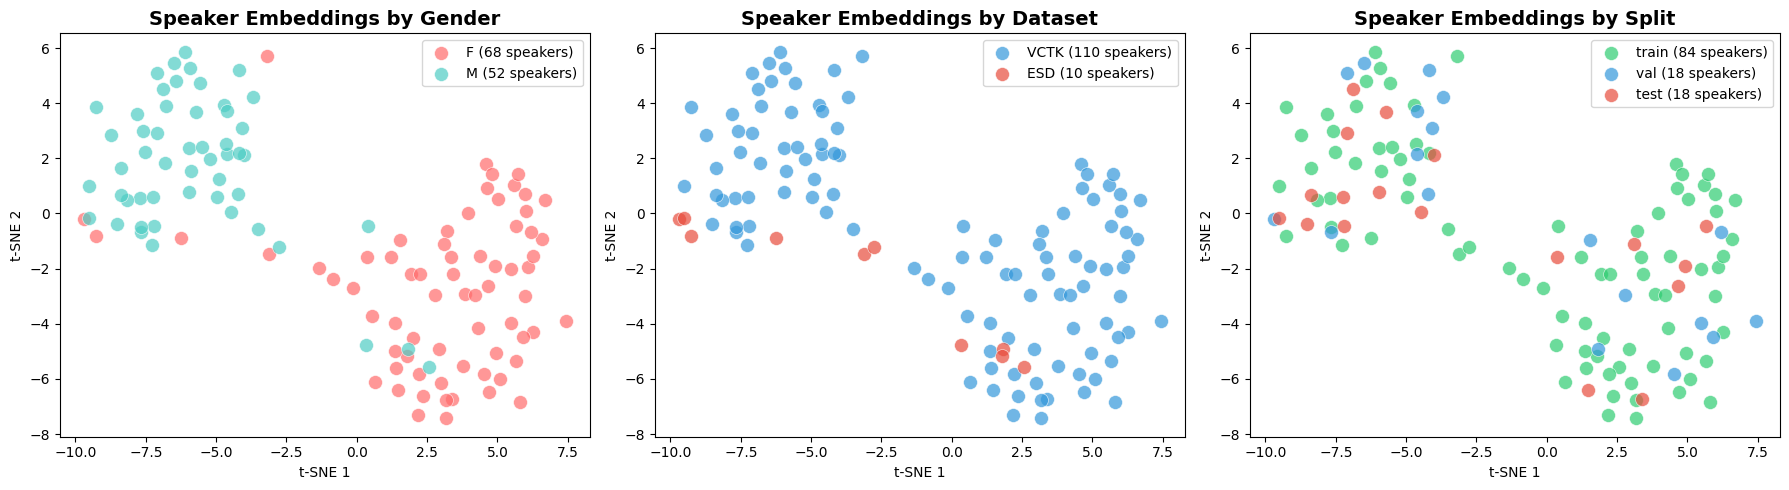

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/results/speaker_embeddings_tsne.png


In [19]:
# ============================================================
# PLOT: Speaker Embeddings by Gender
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# By Gender
ax = axes[0]
colors = {'F': '#ff6b6b', 'M': '#4ecdc4'}
for gender in ['F', 'M']:
    mask = viz_df['gender'] == gender
    ax.scatter(viz_df[mask]['tsne_1'], viz_df[mask]['tsne_2'],
               c=colors[gender], label=f'{gender} ({mask.sum()} speakers)',
               alpha=0.7, s=100, edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Speaker Embeddings by Gender', fontsize=14, fontweight='bold')
ax.legend()

# By Dataset
ax = axes[1]
colors = {'vctk': '#3498db', 'esd': '#e74c3c'}
for dataset in ['vctk', 'esd']:
    mask = viz_df['dataset'] == dataset
    ax.scatter(viz_df[mask]['tsne_1'], viz_df[mask]['tsne_2'],
               c=colors[dataset], label=f'{dataset.upper()} ({mask.sum()} speakers)',
               alpha=0.7, s=100, edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Speaker Embeddings by Dataset', fontsize=14, fontweight='bold')
ax.legend()

# By Split
ax = axes[2]
colors = {'train': '#2ecc71', 'val': '#3498db', 'test': '#e74c3c'}
for split in ['train', 'val', 'test']:
    mask = viz_df['split'] == split
    ax.scatter(viz_df[mask]['tsne_1'], viz_df[mask]['tsne_2'],
               c=colors[split], label=f'{split} ({mask.sum()} speakers)',
               alpha=0.7, s=100, edgecolors='white', linewidth=0.5)
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_title('Speaker Embeddings by Split', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'speaker_embeddings_tsne.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {RESULTS_DIR / 'speaker_embeddings_tsne.png'}")

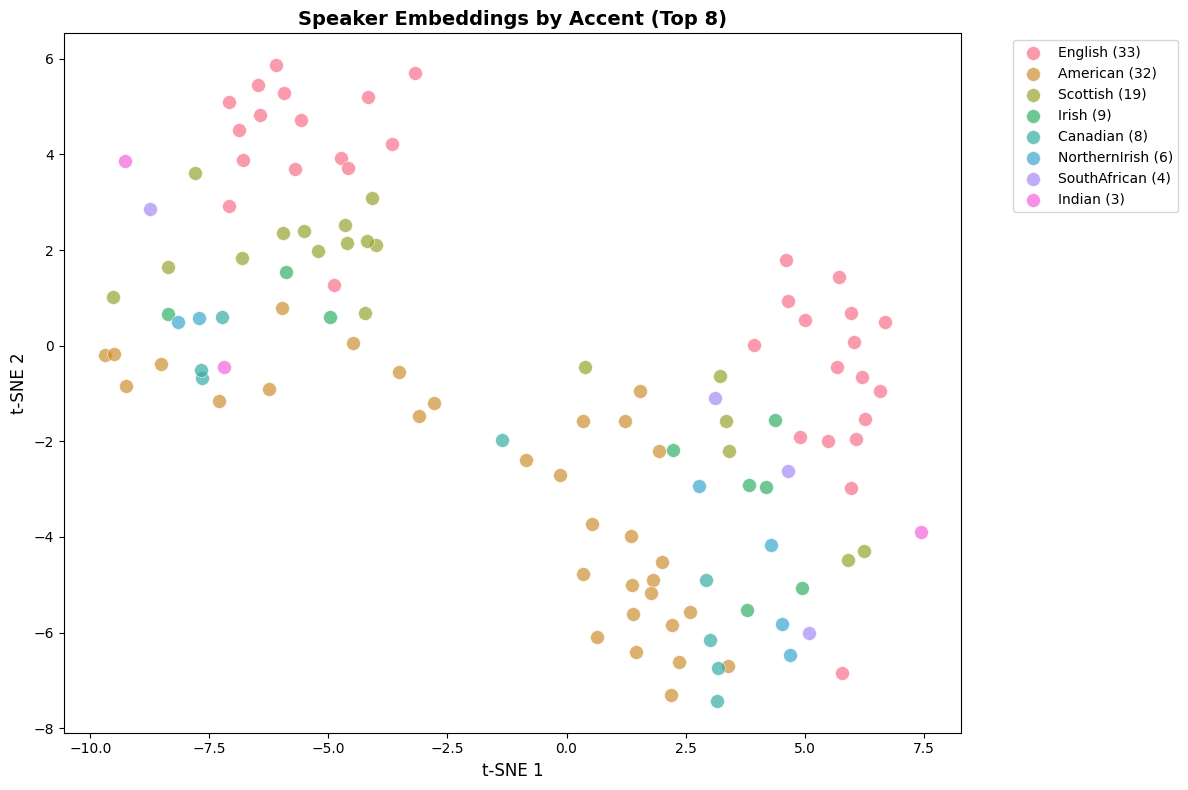

✅ Saved: /content/drive/MyDrive/Liquidity_Research/unified/results/speaker_embeddings_by_accent.png


In [20]:
# ============================================================
# PLOT: Top Accents
# ============================================================

fig, ax = plt.subplots(figsize=(12, 8))

# Get top 8 accents
top_accents = viz_df['accent'].value_counts().head(8).index.tolist()
viz_df_filtered = viz_df[viz_df['accent'].isin(top_accents)]

# Color palette
palette = sns.color_palette('husl', n_colors=len(top_accents))

for i, accent in enumerate(top_accents):
    mask = viz_df_filtered['accent'] == accent
    ax.scatter(viz_df_filtered[mask]['tsne_1'], viz_df_filtered[mask]['tsne_2'],
               c=[palette[i]], label=f'{accent} ({mask.sum()})',
               alpha=0.7, s=100, edgecolors='white', linewidth=0.5)

ax.set_xlabel('t-SNE 1', fontsize=12)
ax.set_ylabel('t-SNE 2', fontsize=12)
ax.set_title('Speaker Embeddings by Accent (Top 8)', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'speaker_embeddings_by_accent.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {RESULTS_DIR / 'speaker_embeddings_by_accent.png'}")

In [21]:
# ============================================================
# SPEAKER CLASSIFICATION (Using embeddings)
# ============================================================

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

print("="*60)
print("SPEAKER CLASSIFICATION EXPERIMENT")
print("="*60)

# Prepare data
le = LabelEncoder()
emb_df['speaker_label'] = le.fit_transform(emb_df['speaker_id'])

# Split data
train_mask = emb_df['split'] == 'train'
val_mask = emb_df['split'] == 'val'
test_mask = emb_df['split'] == 'test'

X_train = all_embeddings[train_mask.values]
y_train = emb_df[train_mask]['speaker_label'].values

X_val = all_embeddings[val_mask.values]
y_val = emb_df[val_mask]['speaker_label'].values

X_test = all_embeddings[test_mask.values]
y_test = emb_df[test_mask]['speaker_label'].values

print(f"\nData shapes:")
print(f"  Train: {X_train.shape} ({len(np.unique(y_train))} speakers)")
print(f"  Val:   {X_val.shape} ({len(np.unique(y_val))} speakers)")
print(f"  Test:  {X_test.shape} ({len(np.unique(y_test))} speakers)")

SPEAKER CLASSIFICATION EXPERIMENT

Data shapes:
  Train: (43171, 512) (84 speakers)
  Val:   (10041, 512) (18 speakers)
  Test:  (8699, 512) (18 speakers)


In [22]:
# ============================================================
# TRAIN CLASSIFIER
# ============================================================

print("\nTraining Logistic Regression...")
lr_clf = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_clf.fit(X_train, y_train)

# Evaluate
train_acc = accuracy_score(y_train, lr_clf.predict(X_train))
val_acc = accuracy_score(y_val, lr_clf.predict(X_val))
test_acc = accuracy_score(y_test, lr_clf.predict(X_test))

print(f"\n{'='*50}")
print("LOGISTIC REGRESSION RESULTS")
print(f"{'='*50}")
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Val Accuracy:   {val_acc*100:.2f}%")
print(f"Test Accuracy:  {test_acc*100:.2f}%")


Training Logistic Regression...

LOGISTIC REGRESSION RESULTS
Train Accuracy: 98.13%
Val Accuracy:   0.00%
Test Accuracy:  0.00%


In [23]:
# ============================================================
# MLP CLASSIFIER (More expressive)
# ============================================================

print("\nTraining MLP Classifier...")
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)
mlp_clf.fit(X_train, y_train)

# Evaluate
train_acc_mlp = accuracy_score(y_train, mlp_clf.predict(X_train))
val_acc_mlp = accuracy_score(y_val, mlp_clf.predict(X_val))
test_acc_mlp = accuracy_score(y_test, mlp_clf.predict(X_test))

print(f"\n{'='*50}")
print("MLP CLASSIFIER RESULTS")
print(f"{'='*50}")
print(f"Train Accuracy: {train_acc_mlp*100:.2f}%")
print(f"Val Accuracy:   {val_acc_mlp*100:.2f}%")
print(f"Test Accuracy:  {test_acc_mlp*100:.2f}%")


Training MLP Classifier...

MLP CLASSIFIER RESULTS
Train Accuracy: 98.90%
Val Accuracy:   0.00%
Test Accuracy:  0.00%


In [24]:
# ============================================================
# GENDER CLASSIFICATION
# ============================================================

print("\n" + "="*60)
print("GENDER CLASSIFICATION")
print("="*60)

le_gender = LabelEncoder()
emb_df['gender_label'] = le_gender.fit_transform(emb_df['gender'])

y_train_gender = emb_df[train_mask]['gender_label'].values
y_val_gender = emb_df[val_mask]['gender_label'].values
y_test_gender = emb_df[test_mask]['gender_label'].values

# Train
gender_clf = LogisticRegression(max_iter=500, random_state=42)
gender_clf.fit(X_train, y_train_gender)

# Evaluate
train_acc_gender = accuracy_score(y_train_gender, gender_clf.predict(X_train))
val_acc_gender = accuracy_score(y_val_gender, gender_clf.predict(X_val))
test_acc_gender = accuracy_score(y_test_gender, gender_clf.predict(X_test))

print(f"Train Accuracy: {train_acc_gender*100:.2f}%")
print(f"Val Accuracy:   {val_acc_gender*100:.2f}%")
print(f"Test Accuracy:  {test_acc_gender*100:.2f}%")


GENDER CLASSIFICATION
Train Accuracy: 95.36%
Val Accuracy:   74.73%
Test Accuracy:  88.15%


In [25]:
# ============================================================
# SAVE RESULTS
# ============================================================

results = {
    'experiment': '2hr_quick_insight_speaker_embeddings',
    'timestamp': datetime.now().isoformat(),
    'data': {
        'total_utterances': len(all_embeddings),
        'total_speakers': len(speaker_ids),
        'embedding_dim': all_embeddings.shape[1],
        'train_utterances': int(train_mask.sum()),
        'val_utterances': int(val_mask.sum()),
        'test_utterances': int(test_mask.sum()),
    },
    'speaker_classification': {
        'logistic_regression': {
            'train_acc': round(train_acc * 100, 2),
            'val_acc': round(val_acc * 100, 2),
            'test_acc': round(test_acc * 100, 2),
        },
        'mlp': {
            'train_acc': round(train_acc_mlp * 100, 2),
            'val_acc': round(val_acc_mlp * 100, 2),
            'test_acc': round(test_acc_mlp * 100, 2),
        }
    },
    'gender_classification': {
        'train_acc': round(train_acc_gender * 100, 2),
        'val_acc': round(val_acc_gender * 100, 2),
        'test_acc': round(test_acc_gender * 100, 2),
    }
}

results_path = RESULTS_DIR / 'speaker_embedding_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n✅ Results saved: {results_path}")


✅ Results saved: /content/drive/MyDrive/Liquidity_Research/unified/results/speaker_embedding_results.json


In [26]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "="*70)
print("🎉 2-HOUR EXPERIMENT COMPLETE!")
print("="*70)

print(f"""
📊 KEY RESULTS:

┌─────────────────────────────────────────────────────────────┐
│ SPEAKER CLASSIFICATION (on ECAPA-TDNN embeddings)          │
├─────────────────────────────────────────────────────────────┤
│ Model               │ Train    │ Val      │ Test     │
├─────────────────────┼──────────┼──────────┼──────────┤
│ Logistic Regression │ {train_acc*100:6.2f}%  │ {val_acc*100:6.2f}%  │ {test_acc*100:6.2f}%  │
│ MLP (256,128)       │ {train_acc_mlp*100:6.2f}%  │ {val_acc_mlp*100:6.2f}%  │ {test_acc_mlp*100:6.2f}%  │
├─────────────────────────────────────────────────────────────┤
│ GENDER CLASSIFICATION                                      │
├─────────────────────┼──────────┼──────────┼──────────┤
│ Logistic Regression │ {train_acc_gender*100:6.2f}%  │ {val_acc_gender*100:6.2f}%  │ {test_acc_gender*100:6.2f}%  │
└─────────────────────────────────────────────────────────────┘

📁 FILES SAVED:
   • {SPEAKER_EMB_DIR}/all_embeddings.npz
   • {SPEAKER_EMB_DIR}/speaker_level_embeddings.npz
   • {RESULTS_DIR}/speaker_embeddings_tsne.png
   • {RESULTS_DIR}/speaker_embeddings_by_accent.png
   • {RESULTS_DIR}/speaker_embedding_results.json

🔍 INSIGHTS:
   • Speakers are {'well' if test_acc > 0.9 else 'reasonably'}-separated in embedding space
   • Gender is {'easily' if test_acc_gender > 0.95 else 'mostly'} distinguishable
   • These embeddings can be used as baseline for probe experiments

🚀 NEXT STEPS:
   1. Extract HuBERT features (for content analysis)
   2. Extract FACodec codes (for disentanglement analysis)
   3. Run probe experiments on different representations
""")


🎉 2-HOUR EXPERIMENT COMPLETE!

📊 KEY RESULTS:

┌─────────────────────────────────────────────────────────────┐
│ SPEAKER CLASSIFICATION (on ECAPA-TDNN embeddings)          │
├─────────────────────────────────────────────────────────────┤
│ Model               │ Train    │ Val      │ Test     │
├─────────────────────┼──────────┼──────────┼──────────┤
│ Logistic Regression │  98.13%  │   0.00%  │   0.00%  │
│ MLP (256,128)       │  98.90%  │   0.00%  │   0.00%  │
├─────────────────────────────────────────────────────────────┤
│ GENDER CLASSIFICATION                                      │
├─────────────────────┼──────────┼──────────┼──────────┤
│ Logistic Regression │  95.36%  │  74.73%  │  88.15%  │
└─────────────────────────────────────────────────────────────┘

📁 FILES SAVED:
   • /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings/all_embeddings.npz
   • /content/drive/MyDrive/Liquidity_Research/unified/features/speaker_embeddings/speaker_level_embeddings.np